# Advaced Models

Testing DATE model with real data

# Dependencies

In [1]:
## basics

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

from datetime import date 
import itertools
from tqdm import tqdm
import warnings
warnings.simplefilter('ignore')

# directories
import os

## plots

import matplotlib.pyplot as plt
import seaborn as sns

## preprocessing

# normalization and nulls imputation
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import norm
from sklearn.impute import SimpleImputer

## modelling Libraries

from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch_multi_head_attention import MultiHeadAttention
from torch.autograd import Variable
import argparse
import time 

# evaluation Libraries
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, roc_auc_score
# train/test
from sklearn.model_selection import train_test_split

# tuning
from sklearn.model_selection import GridSearchCV



## saving results

import joblib

import warnings
warnings.filterwarnings('ignore')

# Data processing

In [2]:
dtypes_dict = {
    # 'Numero Externo Item - ART': str,
    'Codigo Aduana de registro - DDT': str,
    'Via Medio de Transporte - DDT': str,
    'Mercaderia uso - ART': str,
    'Pais de Destinacion - DDT': str,
    'Pais de origen - ART': str,
    'Pais de Procedencia - ART': str,
    'Unidad estadistica - ART': str,
    # 'Indicador deudas S/N': str,
}

#DDT 2014
Dataset = 'Risk_Dataset_2014_Cleaned.csv'
df_DDT_2014 = pd.read_csv(Dataset, sep=",", dtype=dtypes_dict, index_col=0)

# changing '/' to avoiding troubles in saving figures
# df_DDT_2014.columns = df_DDT_2014.columns.str.replace('[/]','-')

# more data types

date_col=['Fecha de Oficializacion - DDT','Fecha de Cumplido - DDT','Fecha de Embarque - DDT',
'Fec. Inicio Act. DESP','Fech. alta Sist. DESP','Fec. Inicio Act. IMEX','Fech. alta Sist. IMEX']

for col in date_col:
    df_DDT_2014[col] = pd.to_datetime(df_DDT_2014[col])

# cleaning tariff codes
df_DDT_2014['Posicion Aranc.SIM-NCE - ART'] = df_DDT_2014['Posicion Aranc.SIM-NCE - ART'].str.replace('.','')

In [3]:
# Separating variables types
target = 'infraccion'
target_bin = 'infraccion bin'

allColumns = list(df_DDT_2014.columns.values)

categorical = df_DDT_2014.drop([target,target_bin], axis = 1).select_dtypes('object').columns.tolist()

numeric = df_DDT_2014.drop([target,target_bin], axis = 1).select_dtypes('number').columns.tolist()

dates = df_DDT_2014.drop([target,target_bin], axis = 1).select_dtypes('datetime64').columns.tolist()

In [4]:
df_IM_2014 = df_DDT_2014[df_DDT_2014['importacion-exportacion(IMPEXP)']=='I']

# shadow columns from missing values
to_shadow = ['Indicador embargos S-N', 'Tonalidad Canal Rojo - DDT', 
             'Fecha de Embarque - DDT', 'Fecha de Cumplido - DDT', 
             'Pais de Destinacion - DDT', 'Via Medio de Transporte - DDT', 
             'Lugar operativo - DDT']

for col in to_shadow:
    df_IM_2014[col + '_shadow'] = df_IM_2014[col].isnull()

In [5]:
# target information
df_IM_2014['infraccion'].fillna('SIN INFRACCION', inplace=True)
df_IM_2014['Minfperjui SUM'].fillna(0, inplace=True)

# binary variables
## Tonalidad Canal Rojo - DDT
df_IM_2014['Tonalidad Canal Rojo - DDT'].replace('VALOR', True, inplace=True)
df_IM_2014['Tonalidad Canal Rojo - DDT'].fillna(False, inplace=True)
## Indicador embargos S-N
df_IM_2014['Indicador embargos S-N'].replace('S', True, inplace=True)
df_IM_2014['Indicador embargos S-N'].replace('N', False, inplace=True)
df_IM_2014['Indicador embargos S-N'].fillna(False, inplace=True)

# dates
## Fecha de Embarque - DDT & Fecha de Cumplido - DDT
to_drop = ['Fecha de Embarque - DDT', 'Fecha de Cumplido - DDT'] # all nulls for imports

# categories
## 'Pais de Destinacion - DDT'
df_IM_2014 = df_IM_2014.loc[df_IM_2014['Pais de Destinacion - DDT'].isnull()] # getting only nulls
to_drop += ['Pais de Destinacion - DDT']
## Via Medio de Transporte - DDT
df_IM_2014['Via Medio de Transporte - DDT'].fillna('HIDRO', inplace=True) # HIDRO / rivers
### renaming transport means
df_IM_2014['Via Medio de Transporte - DDT'].replace('2','AIRE', inplace=True) # AIRE / air
df_IM_2014['Via Medio de Transporte - DDT'].replace('4','TIERRA', inplace=True) # TIERRA / land
df_IM_2014['Via Medio de Transporte - DDT'].replace('8','MAR', inplace=True) # MAR / sea
### others less important means
df_IM_2014['Via Medio de Transporte - DDT'].replace('1','OTRO', inplace=True) # self means
df_IM_2014['Via Medio de Transporte - DDT'].replace('3','OTRO', inplace=True) # railway
df_IM_2014['Via Medio de Transporte - DDT'].replace('5','OTRO', inplace=True) # herding
df_IM_2014['Via Medio de Transporte - DDT'].replace('6','OTRO', inplace=True) # raft
df_IM_2014['Via Medio de Transporte - DDT'].replace('7','OTRO', inplace=True) # oil/gas pipeline
df_IM_2014['Via Medio de Transporte - DDT'].replace('9','OTRO', inplace=True) # electric wires
df_IM_2014['Via Medio de Transporte - DDT'].replace('A','OTRO', inplace=True) # postal

## 'Lugar operativo - DDT'
df_IM_2014['Lugar operativo - DDT'].fillna('SIN LUGAR', inplace=True)

# dropping null columns
df_IM_2014.drop(to_drop, axis=1, inplace=True)

# Cheking nulls
df_IM_2014.isnull().sum().sum()

0

In [6]:
# log transformation
to_log = ['Cantidad Estadistica - ART SUM', 'Peso Neto en Kilos - ART SUM',
       'Monto del Concepto SUM', 'Monto Fob en U$S - ART SUM_y',
       'Cantidad de los Bultos - DDT', 'Monto Fob - DDT SUM']

# tax % imputation
df_IM_2014 = df_IM_2014.loc[df_IM_2014['Coeficiente del Concepto SUM'] < 107]

# weight == 0 imputation
df_IM_2014 = df_IM_2014.loc[df_IM_2014['Peso Neto en Kilos - ART SUM'] != 0.0]

In [7]:
categorical = df_IM_2014.drop(target, axis = 1).select_dtypes('object').columns.tolist()

cate_to_oneHotEncoding = []
cate_to_targetEncoding = []

for col in categorical:
    if df_DDT_2014[col].nunique() < 15:
        cate_to_oneHotEncoding.append(col)
    elif df_DDT_2014[col].nunique() < 500:
        cate_to_targetEncoding.append(col)
    else:
        continue # ignoring categories with huge amount of differente codes

print('categorical variables to one-hot encoding:')
print(cate_to_oneHotEncoding)
print('---'*20)
print('categorical variables to target encoding:')
print(cate_to_targetEncoding)
print('---'*20)

categorical variables to one-hot encoding:
['Via Medio de Transporte - DDT', 'Mercaderia uso - ART', 'Unidad estadistica - ART', 'Tipo DESP', 'Usuario actuante', 'Tipo IMEX', 'importacion-exportacion(IMPEXP)']
------------------------------------------------------------
categorical variables to target encoding:
['Destinacion - DDT', 'Codigo Aduana de registro - DDT', 'Pais de origen - ART', 'Pais de Procedencia - ART']
------------------------------------------------------------


In [8]:
# manual depuration of one-hot encoding

cate_to_oneHotEncoding = ['Via Medio de Transporte - DDT', 'Mercaderia uso - ART']

## Feature selected

In [9]:
var_feature_selection = ['Monto Fob - DDT SUM',
            'IMEX meses de actividad',
            'Tonalidad Canal Rojo - DDT_shadow',
            'Codigo Aduana de registro - DDT_infraccion bin_rate',
            'Indicador embargos S-N_shadow',
            'Destinacion - DDT_infraccion bin_rate',
            'Destinacion - DDT_infraccion bin_sum',
            'Codigo Aduana de registro - DDT_infraccion bin_Qsum',
            'DESP meses de actividad',
            'Codigo Aduana de registro - DDT_act_Q',
            'Lugar operativo - DDT_shadow',
            'Destinacion - DDT&&Codigo Aduana de registro - DDT_infraccion bin_sum',
            'day_of_week',
            'HS06_activity',
            'WUnitprice_3Q+1.5*IQR',
            'Codigo Aduana de registro - DDT&&Pais de origen - ART_infraccion bin_rate',
            'Destinacion - DDT&&Pais de origen - ART_infraccion bin_rate',
            'Destinacion - DDT&&Pais de Procedencia - ART_infraccion bin_rate',
            'Pais de Procedencia - ART_infraccion bin_sum',
            'Coeficiente del Concepto SUM',
            'Pais de Procedencia - ART_infraccion bin_rate',
            'Pais de Procedencia - ART_act',
            'Codigo Aduana de registro - DDT_infraccion bin_Qrate',
            'Destinacion - DDT&&Pais de origen - ART_infraccion bin_Qrate',
            'Codigo Aduana de registro - DDT&&Pais de origen - ART_infraccion bin_Qrate',
            'Codigo Aduana de registro - DDT&&Pais de Procedencia - ART_infraccion bin_Qrate',
            'HS06_WUnitprice_Q',
            'Origen != Procedencia',
            'HS06_Unitprice_Q',
            'Codigo Aduana de registro - DDT&&Pais de Procedencia - ART_infraccion bin_Qsum',
            'Pais de Procedencia - ART_infraccion bin_Qrate',
            'Pais de origen - ART&&Pais de Procedencia - ART_infraccion bin_Qrate',
            'Pais de origen - ART_infraccion bin_Qrate',
            'Codigo Aduana de registro - DDT&&Pais de origen - ART_infraccion bin_Qsum',
            'Destinacion - DDT&&Pais de origen - ART_infraccion bin_Qsum',
            'Pais de origen - ART&&Pais de Procedencia - ART_infraccion bin_Qsum',
            'Destinacion - DDT&&Codigo Aduana de registro - DDT_infraccion bin_Qrate',
            'Pais de origen - ART_act',
            'Destinacion - DDT&&Pais de Procedencia - ART_infraccion bin_sum',
            'Pais de origen - ART_infraccion bin_rate',
            'Pais de origen - ART_infraccion bin_sum',
            'Codigo Aduana de registro - DDT&&Pais de origen - ART_infraccion bin_sum',
            'Pais de origen - ART&&Pais de Procedencia - ART_infraccion bin_rate',
            'Destinacion - DDT&&Pais de origen - ART_infraccion bin_sum',
            'HS06_Unitprice_diff_mean']

## Historical

In [10]:
# Spliting dataset between historical and new data

df_historic = df_IM_2014.sort_values(by='Fecha de Oficializacion - DDT', ascending=True)[:int(len(df_IM_2014)/2)]

OUTPUT_PROFILES = '70-Results/4-Risk profiling'

if not os.path.exists(OUTPUT_PROFILES):
    os.makedirs(OUTPUT_PROFILES)

from risk_profiling_vr1_0 import risk_profiling

df_historic, risk_tables = risk_profiling(df_historic, cate_to_targetEncoding, target='infraccion bin', save=True, output_path=OUTPUT_PROFILES)

risk_tables

profile_candidates ['Destinacion - DDT', 'Codigo Aduana de registro - DDT', 'Pais de origen - ART', 'Pais de Procedencia - ART', 'Destinacion - DDT&&Codigo Aduana de registro - DDT', 'Destinacion - DDT&&Pais de origen - ART', 'Destinacion - DDT&&Pais de Procedencia - ART', 'Codigo Aduana de registro - DDT&&Pais de origen - ART', 'Codigo Aduana de registro - DDT&&Pais de Procedencia - ART', 'Pais de origen - ART&&Pais de Procedencia - ART']


['Destinacion - DDT_hist_sum&rate.csv',
 'Codigo Aduana de registro - DDT_hist_sum&rate.csv',
 'Pais de origen - ART_hist_sum&rate.csv',
 'Pais de Procedencia - ART_hist_sum&rate.csv',
 'Destinacion - DDT&&Codigo Aduana de registro - DDT_hist_sum&rate.csv',
 'Destinacion - DDT&&Pais de origen - ART_hist_sum&rate.csv',
 'Destinacion - DDT&&Pais de Procedencia - ART_hist_sum&rate.csv',
 'Codigo Aduana de registro - DDT&&Pais de origen - ART_hist_sum&rate.csv',
 'Codigo Aduana de registro - DDT&&Pais de Procedencia - ART_hist_sum&rate.csv',
 'Pais de origen - ART&&Pais de Procedencia - ART_hist_sum&rate.csv',
 'Destinacion - DDT_hist_Qsum&Qrate.csv',
 'Codigo Aduana de registro - DDT_hist_Qsum&Qrate.csv',
 'Pais de origen - ART_hist_Qsum&Qrate.csv',
 'Pais de Procedencia - ART_hist_Qsum&Qrate.csv',
 'Destinacion - DDT&&Codigo Aduana de registro - DDT_hist_Qsum&Qrate.csv',
 'Destinacion - DDT&&Pais de origen - ART_hist_Qsum&Qrate.csv',
 'Destinacion - DDT&&Pais de Procedencia - ART_hist_Qs

In [11]:
del df_historic

## Development and test

In [12]:
df_new = df_IM_2014.sort_values(by='Fecha de Oficializacion - DDT', ascending=True)[int(len(df_IM_2014)/2)+1:int(len(df_IM_2014))]

target_info = [target, target_bin,'Minfperjui SUM']

# split train - validation - test
X = df_new.drop(target_info, axis=1)
y = df_new[[target_bin,'Minfperjui SUM']]

X_train_ori, X_test_ori, y_train_ori, y_test_ori = train_test_split(X, y, test_size=0.125, random_state=42)
X_train_ori, X_val_ori, y_train_ori, y_val_ori = train_test_split(X_train_ori, y_train_ori, test_size=0.125, random_state=42)

print(f'X_train: {X_train_ori.shape}, y_train: {y_train_ori.shape}')
print(f'X_val: {X_val_ori.shape}, y_val: {y_val_ori.shape}')
print(f'X_test: {X_test_ori.shape}, y_test: {y_test_ori.shape}')

X_train: (1103382, 36), y_train: (1103382, 2)
X_val: (157626, 36), y_val: (157626, 2)
X_test: (180145, 36), y_test: (180145, 2)


### Train processing

**Feature engineering**

> fit  (activity and stats info)

> transform (new features, merge with risk profiles, log transformations)

**Feature Encoding**

> one hot encoding

**Feature selection and imputation**

> column filtering (with variables selected)

> imputation of missing values

In [13]:
X_train = X_train_ori.copy()
X_val = X_val_ori.copy()
X_test = X_test_ori.copy()

y_train = y_train_ori.copy()
y_val = y_val_ori.copy()
y_test = y_test_ori.copy()

**Feature engineering**

In [14]:
from feature_engine_vr1_1 import Feature_engine

f_engine = Feature_engine(to_comb=cate_to_targetEncoding, 
                          risk_tables=risk_tables,
                          stats_work='read', 
                          save_stats=True, 
                          risk_tables_path=OUTPUT_PROFILES)

f_engine.fit(X_train)
X_train = f_engine.transform(X_train)

# Fitting started

## Calculating basic feature to fit

------------------------
## Processing activity information
Variables: ['Codigo Aduana de registro - DDT', 'Pais de origen - ART', 'Pais de Procedencia - ART']

------------------------
## Reading tariff codes stats information
Stats information read
------------------------

Fitting finished succesfully
------------------------
------------------------
# Transformation started

## Creating new basic features

------------------------
## Creating date related features

------------------------
## Creating activity features
Variables: ['Codigo Aduana de registro - DDT', 'Pais de origen - ART', 'Pais de Procedencia - ART']

------------------------
## Creating period of activity features

------------------------
## Creating tariff codes stats features
Codes: HS06
Variables: ['Unitprice', 'WUnitprice']

Creating new features from stats info
Working on Unitprice stats
Working on WUnitprice stats
------------------------

## Creating 

**One hot encoding**

In [15]:
# simplifying destination codes for one-hot encoding
X_train['Destinacion_XX'] = X_train['Destinacion - DDT'].str[0:2]
cate_to_oneHotEncoding.append('Destinacion_XX')

# adding day of week
cate_to_oneHotEncoding.append('day_of_week')

cate_to_oneHotEncoding

['Via Medio de Transporte - DDT',
 'Mercaderia uso - ART',
 'Destinacion_XX',
 'day_of_week']

In [16]:
X_train = pd.get_dummies(data=X_train, columns=cate_to_oneHotEncoding)

col_from_oneHotEncoding = []

for var in cate_to_oneHotEncoding:
    col_from_oneHotEncoding += [col for col in X_train if (col.startswith(var) and not(col.endswith('shadow')))]

In [17]:
col_from_oneHotEncoding

['Via Medio de Transporte - DDT_AIRE',
 'Via Medio de Transporte - DDT_HIDRO',
 'Via Medio de Transporte - DDT_MAR',
 'Via Medio de Transporte - DDT_OTRO',
 'Via Medio de Transporte - DDT_TIERRA',
 'Mercaderia uso - ART_1',
 'Mercaderia uso - ART_2',
 'Mercaderia uso - ART_3',
 'Mercaderia uso - ART_4',
 'Mercaderia uso - ART_5',
 'Mercaderia uso - ART_6',
 'Destinacion_XX_DI',
 'Destinacion_XX_IC',
 'Destinacion_XX_IG',
 'Destinacion_XX_IS',
 'Destinacion_XX_IT',
 'Destinacion_XX_TG',
 'Destinacion_XX_ZF',
 'day_of_week_0',
 'day_of_week_1',
 'day_of_week_2',
 'day_of_week_3',
 'day_of_week_4',
 'day_of_week_5',
 'day_of_week_6']

In [18]:
###

**Transformation, feature selection and imputation**

In [19]:
to_log

['Cantidad Estadistica - ART SUM',
 'Peso Neto en Kilos - ART SUM',
 'Monto del Concepto SUM',
 'Monto Fob en U$S - ART SUM_y',
 'Cantidad de los Bultos - DDT',
 'Monto Fob - DDT SUM']

In [20]:
# column filtering
var_feature_selection.remove('day_of_week') # it was oneHotEncoded

var_preselected = var_feature_selection + col_from_oneHotEncoding

# log transformation
##

def num_to_log(df, num_col):
    log_numeric = []
    for var in num_col:
        # checking 0 values before log transformation
        if df[var].min() == 0:
            df.loc[df[var] == 0.0, var] = 0.001

        df['log_'+var]=np.log(df[var])
        log_numeric.append('log_'+var)

    return df, log_numeric

## applying log transformation
X_train, log_vars = num_to_log(X_train, to_log)

## adding log vars to preselection
var_preselected += log_vars

X_train = X_train[var_preselected]

# imputations fit and transform
##

# simple imputation handle missing values
X_train.fillna(0, inplace=True)

## standarization
stard = StandardScaler()
X_train[var_preselected] = stard.fit_transform(X_train[var_preselected])

## scale features to the range [0, 1]
scaler = MinMaxScaler()
X_train[var_preselected] = scaler.fit_transform(X_train[var_preselected])

## dropping original numeric and date
# X_train.drop(to_log, axis = 1, inplace=True)

# final selection after transformation
var_selected = X_train.columns.tolist()

In [21]:
var_selected

['Monto Fob - DDT SUM',
 'IMEX meses de actividad',
 'Tonalidad Canal Rojo - DDT_shadow',
 'Codigo Aduana de registro - DDT_infraccion bin_rate',
 'Indicador embargos S-N_shadow',
 'Destinacion - DDT_infraccion bin_rate',
 'Destinacion - DDT_infraccion bin_sum',
 'Codigo Aduana de registro - DDT_infraccion bin_Qsum',
 'DESP meses de actividad',
 'Codigo Aduana de registro - DDT_act_Q',
 'Lugar operativo - DDT_shadow',
 'Destinacion - DDT&&Codigo Aduana de registro - DDT_infraccion bin_sum',
 'HS06_activity',
 'WUnitprice_3Q+1.5*IQR',
 'Codigo Aduana de registro - DDT&&Pais de origen - ART_infraccion bin_rate',
 'Destinacion - DDT&&Pais de origen - ART_infraccion bin_rate',
 'Destinacion - DDT&&Pais de Procedencia - ART_infraccion bin_rate',
 'Pais de Procedencia - ART_infraccion bin_sum',
 'Coeficiente del Concepto SUM',
 'Pais de Procedencia - ART_infraccion bin_rate',
 'Pais de Procedencia - ART_act',
 'Codigo Aduana de registro - DDT_infraccion bin_Qrate',
 'Destinacion - DDT&&Pais 

In [22]:
###

### Validation and test processing

> transform (new features, merge with risk profiles, log transformations)

> column filtering (with variables selected)

> imputation of missing values

In [23]:
cate_to_oneHotEncoding

['Via Medio de Transporte - DDT',
 'Mercaderia uso - ART',
 'Destinacion_XX',
 'day_of_week']

In [24]:
# feature engine transform
##

X_val = f_engine.transform(X_val)
X_test = f_engine.transform(X_test)

# one-hot encoding
##

X_val['Destinacion_XX'] = X_val['Destinacion - DDT'].str[0:2]
X_test['Destinacion_XX'] = X_test['Destinacion - DDT'].str[0:2]

X_val = pd.get_dummies(data=X_val, columns=cate_to_oneHotEncoding)
X_test = pd.get_dummies(data=X_test, columns=cate_to_oneHotEncoding)

# log transformation
##

X_val, _ = num_to_log(X_val, to_log)
X_test, _ = num_to_log(X_test, to_log)

# imputations transform
##

## simple imputation handle missing values
X_test.fillna(0, inplace=True)

## standarization of features
X_val[var_preselected] = stard.transform(X_val[var_preselected])
X_test[var_preselected] = stard.transform(X_test[var_preselected])

## scale features to the range [0, 1]
X_val[var_preselected] = scaler.transform(X_val[var_preselected])
X_test[var_preselected] = scaler.transform(X_test[var_preselected])

## dropping original numeric
# X_val.drop(to_log, axis = 1, inplace=True)
# X_test.drop(to_log, axis = 1, inplace=True)

X_val = X_val[var_selected]
X_test = X_test[var_selected]

# Transformation started

## Creating new basic features

------------------------
## Creating date related features

------------------------
## Creating activity features
Variables: ['Codigo Aduana de registro - DDT', 'Pais de origen - ART', 'Pais de Procedencia - ART']

------------------------
## Creating period of activity features

------------------------
## Creating tariff codes stats features
Codes: HS06
Variables: ['Unitprice', 'WUnitprice']

Creating new features from stats info
Working on Unitprice stats
Working on WUnitprice stats
------------------------

## Creating new caterical features combining the existing ones
Variables to combine: ['Destinacion - DDT', 'Codigo Aduana de registro - DDT', 'Pais de origen - ART', 'Pais de Procedencia - ART']

------------------------
## Matching new training codes with historical risk profiles

------------------------
Transformation finished
------------------------
------------------------
# Transformation started

## Creating new 

**Checking transformations**

In [25]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(1103382, 75)
(157626, 75)
(180145, 75)


In [26]:
X_train.columns == X_val.columns 

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [27]:
X_train.columns == X_test.columns 

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

### Target specification

In [28]:
y.columns

Index(['infraccion bin', 'Minfperjui SUM'], dtype='object')

In [29]:
# binary target
xgb_trainy = y_train['infraccion bin'].values
xgb_validy = y_val['infraccion bin'].values
xgb_testy = y_test['infraccion bin'].values
# revenue increase
revenue_train = y_train['Minfperjui SUM'].values
revenue_valid = y_val['Minfperjui SUM'].values
revenue_test = y_test['Minfperjui SUM'].values

In [30]:
print("Checking data size...")
print(X_train.shape, xgb_trainy.shape, revenue_train.shape)
print(X_val.shape, xgb_validy.shape, revenue_valid.shape)
print(X_test.shape, xgb_testy.shape, revenue_test.shape)

Checking data size...
(1103382, 75) (1103382,) (1103382,)
(157626, 75) (157626,) (157626,)
(180145, 75) (180145,) (180145,)


### Revenue increase normalization

In [31]:
# Normalize revenue by f(x) = log(x+1)/max(xi)
norm_revenue_train = np.log(revenue_train+1)
norm_revenue_valid = np.log(revenue_valid+1)
norm_revenue_test = np.log(revenue_test+1) 
global_max = max(norm_revenue_train) 
norm_revenue_train = norm_revenue_train/global_max
norm_revenue_valid = norm_revenue_valid/global_max
norm_revenue_test = norm_revenue_test/global_max

# Modeling

In [32]:
import multiprocessing

total_cores = multiprocessing.cpu_count()

In [33]:
total_cores

16

## Fast evaluation and best threshold

In [34]:
def find_best_threshold(y_pred_prob, y_test, best_thresh = None):
    """
    This function is to find the best threshold to determine "to inspect" or "not".
    We assume that we inspect only the imports where predicted probability of fraud is above the threshold.

    dtype model: xgboost.sklearn.XGBClassifier
    dtype x_list: list or array
    dtype y_test: np.array
    dtype best_thresh: float
    rtype best_f1: float
    """
    
    # Set threshold range as [0.1, 0.2, ..., 0.5]. 
    threshold_list = np.arange(0.1,0.6,0.1)
    # Set an initial value of best threshold.
    best_f1 = 0
    
    # If best_thresh is set as "None", this function is to find the best_thresh as well as best_f1 
    if best_thresh ==None:
        for th in threshold_list:
            y_pred_label = (y_pred_prob > th)*1 
            f_score = f1_score(y_test,y_pred_label)
            if f_score > best_f1:
                best_f1 = f_score
                best_thresh = th 
        return best_thresh, best_f1, roc_auc_score(y_test, y_pred_prob)
    
    # If best_thresh is set as a certain number, this function is to calculate its f1 score.
    else:
        y_pred_label = (y_pred_prob > best_thresh)*1 
        best_f1 = f1_score(y_test,y_pred_label)
        
    return best_f1, roc_auc_score(y_test, y_pred_prob)

## 1. XGBoost training

In [35]:
# Initiate the model
xgb_clf = XGBClassifier(n_estimators=100, max_depth=4, scale_pos_weight=33, n_jobs=-1)
# Train/fit the model
xgb_clf.fit(X_train,xgb_trainy)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

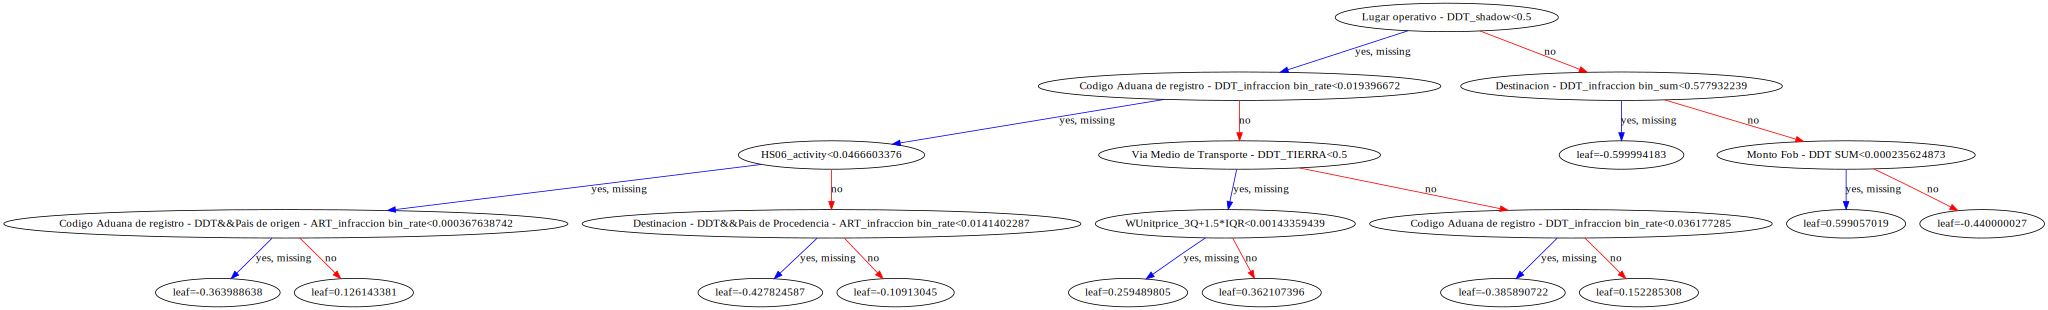

In [36]:
xgb.to_graphviz(booster = xgb_clf, num_trees=0)

In [37]:
# Evaluate xgboost model
print("------Evaluating xgboost model------")
# Predict
test_pred = xgb_clf.predict_proba(X_test)[:,1]
# Calculate auc
xgb_auc = roc_auc_score(xgb_testy, test_pred)

# Find the best threshold
xgb_threshold,_,_ = find_best_threshold(xgb_clf.predict_proba(X_val)[:,1], xgb_validy)
# Calculate the best f1 score
xgb_f1,_ = find_best_threshold(xgb_clf.predict_proba(X_test)[:,1], xgb_testy, best_thresh = xgb_threshold)
print("AUC = %.4f, F1-score = %.4f" % (xgb_auc, xgb_f1))

------Evaluating xgboost model------
AUC = 0.9188, F1-score = 0.1923


In [38]:
xgb_threshold

0.5

## 2. DATE Model (XGB + NN + Attention)

**[Step 1] Preprocessing categories for attention mechanism**

Instead of using importer ids, we will use country of origin

> 'Pais de origen - ART'

> 'Posicion Aranc.SIM-NCE - ART'

In [39]:
# User & item information 
train_raw_countries = X_train_ori['Pais de origen - ART'].values
train_raw_tariff_codes = X_train_ori['Posicion Aranc.SIM-NCE - ART'].values
val_raw_countries = X_val_ori['Pais de origen - ART'].values
val_raw_tariff_codes = X_val_ori['Posicion Aranc.SIM-NCE - ART'].values
test_raw_countries = X_test_ori['Pais de origen - ART'].values
test_raw_tariff_codes = X_test_ori['Posicion Aranc.SIM-NCE - ART'].values

In [40]:
# We need padding for unseen user or item 
countries_set = set(train_raw_countries)
tariff_codes_set = set(train_raw_tariff_codes)

In [41]:
# Remember to +1 for zero padding 
countries_mapping = {v:i+1 for i,v in enumerate(countries_set)} 
tariff_codes_mapping = {v:i+1 for i,v in enumerate(tariff_codes_set)}
countries_size = len(countries_mapping) + 1
tariff_codes_size = len(tariff_codes_mapping) + 1
# Label-encoding
train_countries = [countries_mapping[x] for x in train_raw_countries]
train_tariff_codes = [tariff_codes_mapping[x] for x in train_raw_tariff_codes]

In [42]:
# For test data, we use padding_idx=0 for unseen data
# Use dic.get(key,deafault) to handle unseen
val_countries = [countries_mapping.get(x,0) for x in val_raw_countries]
val_tariff_codes = [tariff_codes_mapping.get(x,0) for x in val_raw_tariff_codes]
test_countries = [countries_mapping.get(x,0) for x in test_raw_countries] 
test_tariff_codes = [tariff_codes_mapping.get(x,0) for x in test_raw_tariff_codes]

**[Step 2] Model functions**

**process_lead_idx** function

In [43]:
def process_leaf_idx(X_leaves): 
    """
    This function is to convert the output of XGBoost model to the input of DATE model.
    For an individual import, the output of XGBoost model is a list of leaf index of multiple trees.
    eg. [1, 1, 10, 9, 30, 30, 32, ... ]
    How to distinguish "node 1" of the first tree from "node 1" of the second tree?
    How to distinguish "node 30" of the fifth tree from "node 30" of the sixth tree?
    This function is to assign unique index to every leaf node in all the trees. 
    
    This function returns;
    - lists of unique leaf index;
    - total number of unique leaf nodes; and
    - a reference table (dictionary) composed of "unique leaf index", "tree id", "(previous) leaf index".
    
    dtype X_leaves: np.array
    rtype leaves: list
    rtype total_leaves: int
    rtype new_leaf_index: dict 
    """
    leaves = X_leaves.copy()
    new_leaf_index = dict() # Dictionary to store leaf index
    total_leaves = 0
    for c in range(X_leaves.shape[1]): # Iterate for each column (i.e. 100 trees)
        column = X_leaves[:,c]
        unique_vals = list(sorted(set(column)))
        new_idx = {v:(i+total_leaves) for i,v in enumerate(unique_vals)}
        for i,v in enumerate(unique_vals):
            leaf_id = i+total_leaves
            new_leaf_index[leaf_id] = {c:v}
        leaves[:,c] = [new_idx[v] for v in column]
        total_leaves += len(unique_vals)
        
    assert leaves.ravel().max() == total_leaves - 1
    return leaves,total_leaves,new_leaf_index

**fgsm_attack** function

This function is to generate adversarial samples.

In [44]:
def fgsm_attack(model, loss, images, labels, eps):
    """
    Generate adversarial examples
    
    dtype model: torch.nn.parallel.data_parallel.DataParallel
    dtype loss: torch.nn.modules.loss.BCELoss
    dtype images: torch.Tensor
    dtype labels: torch.Tensor
    dtype eps: float
    rtype attack_images: torch.Tensor
    """
    
    images = Variable(images, requires_grad=True)
    outputs = model.module.pred_from_hidden(images)
    
    model.zero_grad()
    cost = loss(outputs, labels)
    cost.backward()
    attack_images = images + eps * images.grad.sign()
    
    return attack_images

**metrics** function

This is the function which generates metrics to evaluate the performance of the model.  

For date model, we will calculate the metrics of evaluation for each group of 1%, 2%, 5%, and 10% suspicious transactions suggested by the model.

In [45]:
def metrics(y_prob,xgb_testy,revenue_test,best_thresh=None):
    """
    Generate metrics for evaluation
    
    dtype y_prob: np.array
    dtype xgb_testy: np.array
    dtype revenue_test: np.array
    dtype best_thresh: float64
    rtype overall_f1: float64
    rtype auc: float64
    rtype pr: list
    rtype re: list
    rtype f: list
    rtype rev: list
    """
    
    if best_thresh ==None:
        _,overall_f1,auc = find_best_threshold(y_prob,xgb_testy,best_thresh)
    else:
        overall_f1,auc = find_best_threshold(y_prob,xgb_testy,best_thresh)
    # Seized revenue 
    # Precision and Recall
    pr, re, f, rev = [], [], [], []
    for i in [99,98,95,90]:
        threshold = np.percentile(y_prob, i)

        precision = np.mean(xgb_testy[y_prob > threshold])
        recall = sum(xgb_testy[y_prob > threshold])/sum(xgb_testy)
        f1 = 2*precision*recall/(precision+recall)
        revenue_recall = sum(revenue_test[y_prob > threshold]) /sum(revenue_test)

        # Save results
        pr.append(precision)
        re.append(recall)
        f.append(f1)
        rev.append(revenue_recall)    
    
    return overall_f1,auc,pr, re, f, rev

**[Step 3] Leaf nodes of each import from XGB model**

Get output values from the XGBoost model and convert them to the input form of the DATE model.

In [46]:
# Get leaf index from xgboost model 
X_train_leaves = xgb_clf.apply(X_train) #apply: Return the predicted leaf every tree for each sample.
X_valid_leaves = xgb_clf.apply(X_val)
X_test_leaves = xgb_clf.apply(X_test)
train_rows = X_train_leaves.shape[0]

In [47]:
# Preprocess
train_rows = X_train.shape[0]
valid_rows = X_val.shape[0] + train_rows

# Convert output values of the XGBoost model to the input form of the DATE model.
X_leaves = np.concatenate((X_train_leaves, X_valid_leaves, X_test_leaves), axis=0) # Make sure the dimensionality

transformed_leaves, leaf_num, new_leaf_index = process_leaf_idx(X_leaves)

train_leaves, valid_leaves, test_leaves = transformed_leaves[:train_rows],\
                                          transformed_leaves[train_rows:valid_rows],\
                                          transformed_leaves[valid_rows:]

**[Step 4] Convert data to tensor**

Convert the type of input data used for the DATE model to tensor.  

Tensor is a collection of numbers with specific shape (dimension)

In [48]:
# Convert to torch type
train_leaves = torch.tensor(train_leaves).long()
train_country = torch.tensor(train_countries).long()
train_tariff_code = torch.tensor(train_tariff_codes).long()

valid_leaves = torch.tensor(valid_leaves).long()
valid_country = torch.tensor(val_countries).long()
valid_tariff_code = torch.tensor(val_tariff_codes).long()

test_leaves = torch.tensor(test_leaves).long()
test_country = torch.tensor(test_countries).long()
test_tariff_code = torch.tensor(test_tariff_codes).long()

# cls data
train_label_cls = torch.tensor(xgb_trainy).float()
valid_label_cls = torch.tensor(xgb_validy).float()
test_label_cls = torch.tensor(xgb_testy).float()

# Revenue data 
train_label_reg = torch.tensor(norm_revenue_train).float()
valid_label_reg = torch.tensor(revenue_valid).float()
test_label_reg = torch.tensor(revenue_test).float()

# Create dataset 
train_dataset = Data.TensorDataset(train_leaves,train_country,train_tariff_code,train_label_cls,train_label_reg)
valid_dataset = Data.TensorDataset(valid_leaves,valid_country,valid_tariff_code,valid_label_cls,valid_label_reg)
test_dataset = Data.TensorDataset(test_leaves,test_country,test_tariff_code,test_label_cls,test_label_reg)

**Data loaders**

Divide datasets into the batch size, and set the directory and the filename to save the model.

In [49]:
# Create dataloader
batch_size = 256
train_loader = Data.DataLoader(
    dataset=train_dataset,     
    batch_size=batch_size,      
    shuffle=True,               
)
valid_loader = Data.DataLoader(
    dataset=valid_dataset,     
    batch_size=batch_size,      
    shuffle=False,               
)
test_loader = Data.DataLoader(
    dataset=test_dataset,     
    batch_size=batch_size,      
    shuffle=False,               
)

# Model information
curr_time = str(time.time())
model_name = "DATE"
model_path = "./saved_models/%s%s.pkl" % (model_name,curr_time)

**[Step 5] Model contruction**

Layers of the model as classes

* **Mish**

    Mish is one of the activation functions that is similar to ReLU. However, it accepts small negative values and it is continuously differentiable.

In [50]:
class Mish(nn.Module):
    """
    Mish is one of the activation functions that is similar to ReLU. 
    However, it accepts small negative values and it is continuously differentiable.
    """
    def __init__(self):
        super(Mish,self).__init__()
        
    def forward(self, x):
        return x *( torch.tanh(F.softplus(x)))

* **Attention**

    Attention sends all outputs of the encoder to the decoder, and at each time step, the memory cell of the decoder calculates the sum of the weights from all encoder outputs to determine which data to focus more on.

In [51]:
class Attention(nn.Module):
    """
    Attention sends all outputs of the encoder to the decoder, and at each time step, 
    the memory cell of the decoder calculates the sum of the weights from all encoder outputs 
    to determine which data to focus more on.
    """
    def __init__(self,dim,hidden,aggregate="sum"):
        super(Attention, self).__init__()
        self.attention_matrix = nn.Linear(dim, hidden)
        self.project_weight = nn.Linear(hidden*2,hidden)
        self.h = nn.Parameter(torch.rand(hidden,1))
        self.agg_type = aggregate
        
    def forward(self, query, key): # Query: 256 X 16, # key: 256 X 100 X 16, # Assume key==value
        dim = query.size(-1) # 16 (n_embedding_dimension)
        batch = key.size(0) # 256 (batch_size = n_observation in a batch)
        time_step = key.size(1) # 100 (n_trees from xgboot model)
        
        # Concate input query and key 
        query = query.view(batch,1,dim) # View = reshape: (256X16) -> (256X1X16)
        query = query.expand(batch,time_step,-1) # Expand to the same dimension: (256X1X16) -> (256X100X16)
        cat_vector = torch.cat((query,key),dim=-1) # (256X100X32)
        
        # Project to single value
        project_vector = self.project_weight(cat_vector) 
        project_vector = torch.relu(project_vector)
        attention_alpha = torch.matmul(project_vector,self.h)
        attention_weight = torch.softmax(attention_alpha, dim=1) # Normalize and calculate weights (b,t,1)
        attention_vec = key * attention_weight
        
        # Aggregate leaves
        if self.agg_type == "max":
            attention_vec,_ = torch.max(attention_vec,dim=1)
        elif self.agg_type =="mean":
            attention_vec = torch.mean(attention_vec,dim=1)
        elif self.agg_type =="sum":
            attention_vec = torch.sum(attention_vec,dim=1)
        return attention_vec, attention_weight

* **FusionAttention**

    Create the class  for `Multi-head Self-attention`
    - `multi-head attention`: Self-iteration is repeated in multiple times to achieve its robustness.
    - `Self-attention`: The numeric value (importance, weight) of each leaf-id is adjusted based on its correlation/interaction with other leaf-ids.

In [52]:
class FusionAttention(nn.Module):
    """
    Create the class  for `Multi-head Self-attention`
        - `multi-head attention`: Self-iteration is repeated in multiple times to achieve its robustness.
        - `Self-attention`: The numeric value (importance, weight) of each leaf-id is adjusted 
                            based on its correlation/interaction with other leaf-ids.
    """
    def __init__(self,dim):
        super(FusionAttention, self).__init__()
        self.attention_matrix = nn.Linear(dim, dim) # nn.Linear(size of input, size of output)
        self.project_weight = nn.Linear(dim,1)
        
    def forward(self, inputs):
        query_project = self.attention_matrix(inputs) # (b,t,d) -> (b,t,d2)
        query_project = F.leaky_relu(query_project)
        project_value = self.project_weight(query_project) # (b,t,h) -> (b,t,1)
        attention_weight = torch.softmax(project_value, dim=1) # Normalize and calculate weights (b,t,1)
        attention_vec = inputs * attention_weight
        attention_vec = torch.sum(attention_vec,dim=1)
        return attention_vec, attention_weight

* **DATE**

    Define the DATE model class based on layers above.

In [53]:
class DATE(nn.Module):
    """
    This is the class to make the entire structure of the DATE model
    """
    def __init__(self,
                 max_leaf,importer_size,item_size,dim,
                 head_num=4,fusion_type="concat",act="relu",device="cuda",use_self=True,agg_type="sum"):
        super(DATE, self).__init__()
        self.d = dim
        self.device = device
        if act == "relu":
            self.act = nn.LeakyReLU()
        elif act == "mish":
            self.act = Mish() 
        self.fusion_type = fusion_type
        self.use_self = use_self

        # Embedding layers 
        self.leaf_embedding = nn.Embedding(max_leaf,dim)
        self.user_embedding = nn.Embedding(importer_size,dim,padding_idx=0)
        self.user_embedding.weight.data[0] = torch.zeros(dim)
        self.item_embedding = nn.Embedding(item_size,dim,padding_idx=0)
        self.item_embedding.weight.data[0] = torch.zeros(dim)

        # Attention layer
        self.attention_bolck = Attention(dim,dim,agg_type).to(device)
        self.self_att = MultiHeadAttention(dim,head_num).to(device)
        self.fusion_att = FusionAttention(dim)

        # Hidden & output layer
        self.layer_norm = nn.LayerNorm((100,dim))
        self.fussionlayer = nn.Linear(dim*3,dim)
        self.hidden = nn.Linear(dim,dim)
        self.output_cls_layer = nn.Linear(dim,1)
        self.output_reg_layer = nn.Linear(dim,1)
    
    def forward(self,feature,uid,item_id):
        
        # Embedding of leaf_id
        leaf_vectors = self.leaf_embedding(feature)
        
        # 1st attention: Multi-Head Self-Attention
        # Calculate the weight(importance) of each leaf(cross-feature) based on the correlation with other leaves
        if self.use_self:
            # Apply multy head attention
            leaf_vectors = self.self_att(leaf_vectors,leaf_vectors,leaf_vectors)
            # Normalization?
            leaf_vectors = self.layer_norm(leaf_vectors)
        
        # Embedding of importer_id
        importer_vector = self.user_embedding(uid)
        # Embedding of item_id
        item_vector = self.item_embedding(item_id)
        # Multiply embeddings of importer_id and item_id
        query_vector = importer_vector * item_vector
        
        # 2nd attention: Attention with leaf_id, importer_id and item_id (all embeddings)
        set_vector, self.attention_w = self.attention_bolck(query_vector,leaf_vectors)
        
        # Concat the user, item and tree vectors into a fusion attention
        if self.fusion_type == "concat":
            fusion = torch.cat((importer_vector, item_vector, set_vector), dim=-1) # Attach as columns
            fusion = self.act(self.fussionlayer(fusion))
        elif self.fusion_type == "attention":
            importer_vector=importer_vector.view(-1,1,self.d), 
            item_vector=item_vector.view(-1,1,self.d), 
            set_vector=set_vector.view(-1,1,self.d)
            fusion = torch.cat((importer_vector, item_vector, set_vector), dim=1) # Attach as columns
            fusion,_ = self.fusion_att(fusion)
        else:
            raise "Fusion type error"
        hidden = self.hidden(fusion)
        hidden = self.act(hidden)

        # Multi-task output 
        classification_output = torch.sigmoid(self.output_cls_layer(hidden))
        regression_output = torch.relu(self.output_reg_layer(hidden))
        return classification_output, regression_output, hidden

    def pred_from_hidden(self,hidden):
        classification_output = torch.sigmoid(self.output_cls_layer(hidden))
        return classification_output 

    def eval_on_batch(self,test_loader): # Predict test data using batch 
        final_output = []
        cls_loss = []
        reg_loss = []
        for batch in test_loader:
            batch_feature, batch_user, batch_item, batch_cls, batch_reg = batch
            batch_feature,batch_user,batch_item,batch_cls,batch_reg =  \
            batch_feature.to(self.device), batch_user.to(self.device),\
            batch_item.to(self.device), batch_cls.to(self.device), batch_reg.to(self.device)
            batch_cls,batch_reg = batch_cls.view(-1,1), batch_reg.view(-1,1)
            y_pred_prob, y_pred_rev,_ = self.forward(batch_feature,batch_user,batch_item)

            # Compute classification loss
            cls_losses = nn.BCELoss()(y_pred_prob,batch_cls)
            cls_loss.append(cls_losses.item())

            # Compute regression loss 
            reg_losses = nn.MSELoss()(y_pred_rev, batch_reg)
            reg_loss.append(reg_losses.item())

            # Store predicted probability 
            y_pred = y_pred_prob.detach().cpu().numpy().tolist()
            final_output.extend(y_pred)

        print("CLS loss: %.4f, REG loss: %.4f"% (np.mean(cls_loss), np.mean(reg_loss)) )
        return np.array(final_output).ravel(), np.mean(cls_loss)+ np.mean(reg_loss)

**[Step 6] Hyperparameters**

Set the hyperparameters of the model in advance.

In [54]:
# Parse argument
parser = argparse.ArgumentParser()
parser.add_argument('--model_name', 
                        type=str, 
                        default="DATE_AR", 
                        help="Name of model",
                        )
parser.add_argument('--epoch', 
                        type=int, 
                        default=10, 
                        help="Number of epochs",
                        )
parser.add_argument('--dim', 
                        type=int, 
                        default=16, 
                        help="Hidden layer dimension",
                        )
parser.add_argument('--lr', 
                        type=float, 
                        default=0.005, 
                        help="learning rate",
                        )
parser.add_argument('--l2',
                        type=float,
                        default=0.00,
                        help="l2 reg",
                        )
parser.add_argument('--alpha',
                        type=float,
                        default=10,
                        help="Regression loss weight",
                        )

parser.add_argument('--beta', type=float, default=0.00, help="Adversarial loss weight")
parser.add_argument('--head_num', type=int, default=4, help="Number of heads for self attention")
parser.add_argument('--use_self', type=int, default=1, help="Wheter to use self attention")
parser.add_argument('--fusion', type=str, choices=["concat","attention"], default="concat", help="Fusion method for final embedding")
parser.add_argument('--agg', type=str, choices=["sum","max","mean"], default="sum", help="Aggreate type for leaf embedding")
parser.add_argument('--act', type=str, choices=["mish","relu"], default="relu", help="Activation function")
parser.add_argument('--device', type=str, choices=["cuda","cpu"], default="cuda", help="device name for training")
parser.add_argument('--output', type=str, default="full.csv", help="Name of output file")
parser.add_argument('--save', type=int, default=0, help="save model or not")

_StoreAction(option_strings=['--save'], dest='save', nargs=None, const=None, default=0, type=<class 'int'>, choices=None, required=False, help='save model or not', metavar=None)

In [55]:
torch.cuda.is_available()

True

In [56]:
args = parser.parse_args([])
# Why an empty list?
# Refer to: https://stackoverflow.com/questions/50763033/argparse-in-jupyter-notebook-throws-a-typeerror

**[Step 7] Train**

We will progress the training of the DATE model through datasets, functions and classes we produced.

First, make directories to save the trained model and the record of the model performance.

In [57]:
# Prepare directory for saving results.
if not os.path.exists('./saved_models'):
    os.makedirs('./saved_models')
if not os.path.exists('./results'):
    os.makedirs('./results')  

Create the function to train the model with the hyperparameters we have already set.

In [58]:
def train(args):
    """
    Train the DATE model with predefined hyperparameters
    
    dtype *args: strings
    """
    # Get configs
    epochs = args.epoch
    dim = args.dim
    lr = args.lr
    weight_decay = args.l2
    head_num = args.head_num
    device = args.device
    act = args.act
    fusion = args.fusion
    beta = args.beta
    alpha = args.alpha
    use_self = args.use_self
    agg = args.agg
    
    model = DATE(leaf_num,countries_size,tariff_codes_size,\
                                    dim,head_num,\
                                    fusion_type=fusion,act=act,device=device,\
                                    use_self=use_self,agg_type=agg,
                                    ).to(device)
    
    model = nn.DataParallel(model,device_ids=[0])

    # Initialize parameters
    # Fills the input Tensor with values according to the method described in 
    # Understanding the difficulty of training deep feedforward neural networks - Glorot, X. & Bengio, Y. (2010), 
    # Using a uniform distribution.
    
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    # Optimizer & loss 
    optimizer = Adam(model.parameters(), weight_decay=weight_decay,lr=lr)
    cls_loss_func = nn.BCELoss()
    reg_loss_func = nn.MSELoss()

    # Save best model
    global_best_score = 0

    # Early stop settings 
    stop_rounds = 3
    no_improvement = 0
    current_score = None 

    for epoch in range(epochs):
        for step, (batch_feature,batch_user,batch_item,batch_cls,batch_reg) in enumerate(train_loader):
            model.train() # prep to train model
            batch_feature,batch_user,batch_item,batch_cls,batch_reg =  \
            batch_feature.to(device), batch_user.to(device), batch_item.to(device),\
             batch_cls.to(device), batch_reg.to(device)
            batch_cls,batch_reg = batch_cls.view(-1,1), batch_reg.view(-1,1)

            # Model output
            classification_output, regression_output, hidden_vector = model(batch_feature,batch_user,batch_item)

            # FGSM attack
            adv_vector = fgsm_attack(model,cls_loss_func,hidden_vector,batch_cls,0.01)
            adv_output = model.module.pred_from_hidden(adv_vector) 

            # Calculate loss
            adv_loss_func = nn.BCELoss(weight=batch_cls) 
            adv_loss = beta * adv_loss_func(adv_output,batch_cls) 
            cls_loss = cls_loss_func(classification_output,batch_cls)
            revenue_loss = alpha * reg_loss_func(regression_output, batch_reg)
            loss = cls_loss + revenue_loss + adv_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (step+1) % 1000 ==0:  
                print("CLS loss:%.4f, REG loss:%.4f, ADV loss:%.4f, Loss:%.4f"\
                %(cls_loss.item(),revenue_loss.item(),adv_loss.item(),loss.item()))
                
        # Evaluate 
        model.eval()
        print("Validate at epoch %s"%(epoch+1))
        y_prob, val_loss = model.module.eval_on_batch(valid_loader)
        best_threshold, val_score, roc = find_best_threshold(y_prob,xgb_validy)
        overall_f1, auc, precisions, recalls, f1s, revenues = metrics(y_prob,xgb_validy,revenue_valid)
        select_best = np.mean(f1s)
        print("Over-all F1:%.4f, AUC:%.4f, F1-top:%.4f" % (overall_f1, auc, select_best) )

        print("Evaluate at epoch %s"%(epoch+1))
        y_prob, val_loss = model.module.eval_on_batch(test_loader)
        overall_f1, auc, precisions, recalls, f1s, revenues = metrics(y_prob,xgb_testy,revenue_test,best_thresh=best_threshold)
        print("Over-all F1:%.4f, AUC:%.4f, F1-top:%.4f" %(overall_f1, auc, np.mean(f1s)) )

        # Save best model 
        if select_best > global_best_score:
            global_best_score = select_best
            torch.save(model,model_path)
        
         # Early stopping 
        if current_score == None:
            current_score = select_best
            continue
        if select_best < current_score:
            current_score = select_best
            no_improvement += 1
        if no_improvement >= stop_rounds:
            print("Early stopping...")
            break 
        if select_best > current_score:
            no_improvement = 0
            current_score = None

Train the model by using the function above.

In [60]:
# increasing the numbers of epochs
args.epoch = 50

train(args)

CLS loss:0.1007, REG loss:0.0000, ADV loss:0.0000, Loss:0.1007
CLS loss:0.0751, REG loss:0.0000, ADV loss:0.0000, Loss:0.0751
CLS loss:0.0463, REG loss:0.0000, ADV loss:0.0000, Loss:0.0463
CLS loss:0.0855, REG loss:0.0000, ADV loss:0.0000, Loss:0.0855
Validate at epoch 1
CLS loss: 0.0781, REG loss: 42471.4125
Over-all F1:0.4718, AUC:0.9400, F1-top:0.4077
Evaluate at epoch 1
CLS loss: 0.0793, REG loss: 12912.7415
Over-all F1:0.4610, AUC:0.9395, F1-top:0.4060
CLS loss:0.0273, REG loss:0.0000, ADV loss:0.0000, Loss:0.0273
CLS loss:0.0809, REG loss:0.0048, ADV loss:0.0000, Loss:0.0857
CLS loss:0.0996, REG loss:0.0000, ADV loss:0.0000, Loss:0.0996
CLS loss:0.0919, REG loss:0.0000, ADV loss:0.0000, Loss:0.0919
Validate at epoch 2
CLS loss: 0.0741, REG loss: 42471.4125
Over-all F1:0.4873, AUC:0.9444, F1-top:0.4267
Evaluate at epoch 2
CLS loss: 0.0755, REG loss: 12912.7415
Over-all F1:0.4801, AUC:0.9436, F1-top:0.4229
CLS loss:0.0664, REG loss:0.0000, ADV loss:0.0000, Loss:0.0664
CLS loss:0.05

**[Step 8] Evaluation**

Checking the performance of the trained model.

In [61]:
# Check the performance of the model.
def evaluate(save_model):
    """
    Evaluate the trained DATE model
    
    dtype save_model: float64
    rtype overall_f1: float64
    rtype auc: float64
    rtype precisions: list
    rtype recalls: list
    rtype f1s: list
    rtype revenues: list
    """
    print("\n--------Evaluating DATE model---------")
    # Create best model
    best_model = torch.load(model_path)
    best_model.eval()

    # Get threshold
    y_prob, val_loss = best_model.module.eval_on_batch(valid_loader)
    best_threshold, val_score, roc = find_best_threshold(y_prob, xgb_validy)

    # Predict test 
    y_prob, val_loss = best_model.module.eval_on_batch(test_loader)
    
    overall_f1, auc, precisions, recalls, f1s, revenues = metrics(y_prob,xgb_testy,revenue_test,best_threshold)

    if save_model:
        scored_name = "./saved_models/%s_%.4f.pkl" % (model_name,overall_f1)
        torch.save(best_model,scored_name)
    
    return overall_f1, auc, precisions, recalls, f1s, revenues

In [62]:
overall_f1, auc, precisions, recalls, f1s, revenues = evaluate(model_path)


--------Evaluating DATE model---------
CLS loss: 0.0825, REG loss: 42471.4125
CLS loss: 0.0828, REG loss: 12912.7415


We will record The performance of the model to the CSV file.

In [63]:
# Save result
output_file =  "./results/full.csv"
print("Saving result...",output_file)
with open(output_file, 'a') as ff:

    print("""\nMetrics:\nf1:%.4f auc:%.4f\nPr@1:%.4f Pr@2:%.4f Pr@5:%.4f Pr@10:%.4f\nRe@1:%.4f Re@2:%.4f Re@5:%.4f Re@10:%.4f\nRev@1:%.4f Rev@2:%.4f Rev@5:%.4f Rev@10:%.4f""" \
          % (overall_f1, auc,\
             precisions[0],precisions[1],precisions[2],precisions[3],\
             recalls[0],recalls[1],recalls[2],recalls[3],\
             revenues[0],revenues[1],revenues[2],revenues[3]
            ),
        ) 
    output_metric = [16,overall_f1,auc] + precisions + recalls + revenues
    output_metric = list(map(str,output_metric))
    print(" ".join(output_metric),file=ff) 

Saving result... ./results/full.csv

Metrics:
f1:0.5471 auc:0.9474
Pr@1:0.8940 Pr@2:0.6930 Pr@5:0.3954 Pr@10:0.2431
Re@1:0.2895 Re@2:0.4487 Re@5:0.6401 Re@10:0.7869
Rev@1:0.7065 Rev@2:0.9374 Rev@5:0.9420 Rev@10:0.9457


### Fraud detection vs. Inspection rate

In [64]:
# model_path = './saved_models/DATE1704682482.2265375.pkl'

In [65]:
best_model = torch.load(model_path)
best_model.eval()

y_prob, val_loss = best_model.module.eval_on_batch(test_loader)

df_result = pd.DataFrame({'illicit': y_test['infraccion bin'],
            'revenue': y_test['Minfperjui SUM'],
            'proba':y_prob})

df_result.sort_values(by='proba', ascending=False, inplace=True)

total_frauds = df_result['illicit'].sum()
total_revenue = df_result['revenue'].sum()

inspection_rate = []
detection_rate = []
revenue_total = []
revenue_rate = []

for i in range(1, 101):
    rows = int(i*len(df_result)/100)

    detection_rate_i = df_result.head(rows)['illicit'].sum()/total_frauds
    revenue_total_i = df_result.head(rows)['revenue'].sum()
    revenue_rate_i = revenue_total_i/total_revenue
    
    inspection_rate.append(i)
    detection_rate.append(detection_rate_i)
    revenue_total.append(revenue_total_i)
    revenue_rate.append(revenue_rate_i)

del df_result

df_insp_rate =pd.DataFrame({'inspection_rate': inspection_rate,
                            f'detection_rate_{model_name}': detection_rate,
                            f'revenue_total_{model_name}':revenue_total,
                            f'revenue_rate_{model_name}':revenue_rate})

CLS loss: 0.0828, REG loss: 12912.7415


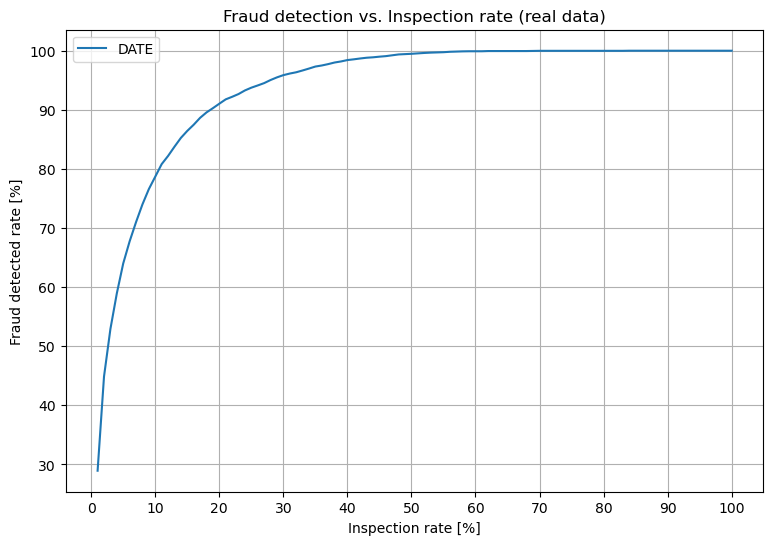

In [66]:
# Plotting
plt.figure(figsize=(9, 6))

plt.plot(df_insp_rate['inspection_rate'], 100*df_insp_rate['detection_rate_DATE'], label='DATE')

# Adding labels and title
plt.xlabel('Inspection rate [%]')
plt.ylabel('Fraud detected rate [%]')
plt.title('Fraud detection vs. Inspection rate (real data)')
plt.legend()
plt.xticks(range(0, 101, 10))

plt.grid(True)
# Show the plot
plt.show()

In [67]:
df_insp_rate_classic = pd.read_csv('df_insp_rate_classic_models_with_revenue', index_col=0)

In [68]:
df_insp_rate = pd.merge(df_insp_rate, df_insp_rate_classic, on='inspection_rate')

In [69]:
df_insp_rate_summary = df_insp_rate.loc[df_insp_rate['inspection_rate'].isin([1, 3, 10, 20, 30, 40, 50])]\
    .set_index('inspection_rate').T

df_insp_rate_summary

inspection_rate,1,3,10,20,30,40,50
detection_rate_DATE,0.289308,0.529200,0.786882,0.910332,0.958670,0.984187,0.994789
revenue_total_DATE,194060.030000,258422.930000,259763.470000,259923.470000,259923.470000,260801.570000,274670.270000
revenue_rate_DATE,0.706520,0.940848,0.945728,0.946311,0.946311,0.949508,1.000000
detection_rate_LogReg_R,0.040430,0.116648,0.324236,0.573952,0.766818,0.890827,0.965006
revenue_total_LogReg_R,19759.420000,20259.460000,524723.420000,526459.910000,680148.860000,856242.520000,921395.030000
revenue_rate_LogReg_R,0.020981,0.021512,0.557152,0.558996,0.722183,0.909160,0.978339
detection_rate_LGBM_R,0.104643,0.197735,0.503964,0.773613,0.914949,0.978029,0.998188
revenue_total_LGBM_R,12436.120000,43565.120000,605713.160000,732493.580000,856187.130000,912464.020000,930076.730000
revenue_rate_LGBM_R,0.013205,0.046258,0.643147,0.777763,0.909101,0.968856,0.987557
detection_rate_XGB_R,0.257984,0.499660,0.825708,0.956852,0.988335,0.996602,0.999207


**Detection rate**

|                         |         1 |        3 |       10 |       20 |       30 |       40 |       50 |
|:------------------------|----------:|---------:|---------:|---------:|---------:|---------:|---------:|
| detection_rate_DATE     | 0.289308  | 0.5292   | 0.786882 | 0.910332 | 0.95867  | 0.984187 | 0.994789 |
| detection_rate_LogReg_R | 0.0404304 | 0.116648 | 0.324236 | 0.573952 | 0.766818 | 0.890827 | 0.965006 |
| detection_rate_LGBM_R   | 0.104643  | 0.197735 | 0.503964 | 0.773613 | 0.914949 | 0.978029 | 0.998188 |
| detection_rate_XGB_R    | 0.257984  | 0.49966  | 0.825708 | 0.956852 | 0.988335 | 0.996602 | 0.999207 |


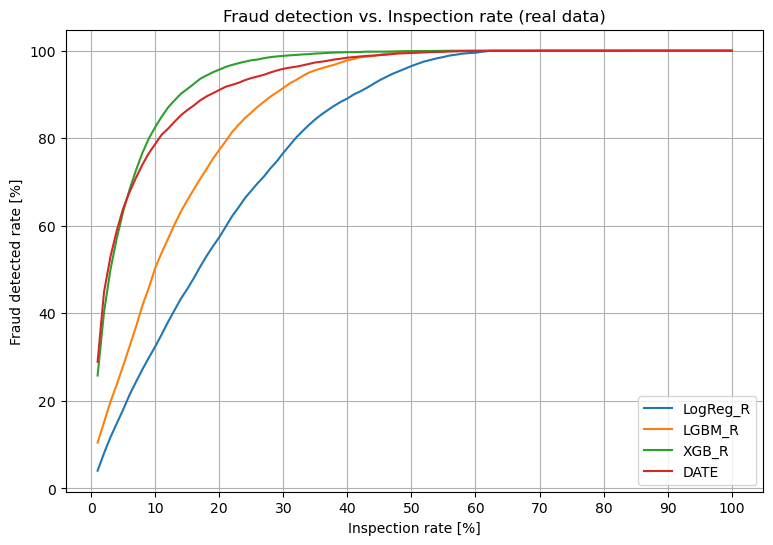

In [70]:
df_detection = df_insp_rate_summary[df_insp_rate_summary.index.str.startswith('detection')]

print(df_detection.to_markdown())

# Plotting
plt.figure(figsize=(9, 6))

plt.plot(df_insp_rate['inspection_rate'], 100*df_insp_rate['detection_rate_LogReg_R'], label='LogReg_R')
plt.plot(df_insp_rate['inspection_rate'], 100*df_insp_rate['detection_rate_LGBM_R'], label='LGBM_R')
plt.plot(df_insp_rate['inspection_rate'], 100*df_insp_rate['detection_rate_XGB_R'], label='XGB_R')
plt.plot(df_insp_rate['inspection_rate'], 100*df_insp_rate['detection_rate_DATE'], label='DATE')


# Adding labels and title
plt.xlabel('Inspection rate [%]')
plt.ylabel('Fraud detected rate [%]')
plt.title('Fraud detection vs. Inspection rate (real data)')
plt.legend()
plt.xticks(range(0, 101, 10))

plt.grid(True)
# Show the plot
plt.show()

**Total revenue increase**

It shows amount comparisons from different test split

In [71]:
# df_revenue_total = df_insp_rate_summary[df_insp_rate_summary.index.str.startswith('revenue_total')]

# print(df_revenue_total.to_markdown())

# # Plotting
# plt.figure(figsize=(9, 6))

# plt.plot(df_insp_rate['inspection_rate'], df_insp_rate['revenue_total_LogReg_R'], label='LogReg_R')
# plt.plot(df_insp_rate['inspection_rate'], df_insp_rate['revenue_total_LGBM_R'], label='LGBM_R')
# plt.plot(df_insp_rate['inspection_rate'], df_insp_rate['revenue_total_XGB_R'], label='XGB_R')
# plt.plot(df_insp_rate['inspection_rate'], df_insp_rate['revenue_total_DATE'], label='DATE')

# # Adding labels and title
# plt.xlabel('inspection rate')
# plt.ylabel('Revenue recovered [US$]')
# plt.title('Revenue recovered vs. Inspection rate (real data)')
# plt.legend()
# plt.xticks(range(0, 101, 10))

# plt.grid(True)
# # Show the plot
# plt.show()

**Revenue rate increase**

|                       |         1 |         3 |       10 |       20 |       30 |       40 |       50 |
|:----------------------|----------:|----------:|---------:|---------:|---------:|---------:|---------:|
| revenue_rate_DATE     | 0.70652   | 0.940848  | 0.945728 | 0.946311 | 0.946311 | 0.949508 | 1        |
| revenue_rate_LogReg_R | 0.0209806 | 0.0215115 | 0.557152 | 0.558996 | 0.722183 | 0.90916  | 0.978339 |
| revenue_rate_LGBM_R   | 0.0132047 | 0.0462575 | 0.643147 | 0.777763 | 0.909101 | 0.968856 | 0.987557 |
| revenue_rate_XGB_R    | 0.830023  | 0.880463  | 0.90124  | 0.950827 | 0.952075 | 0.973572 | 0.973572 |


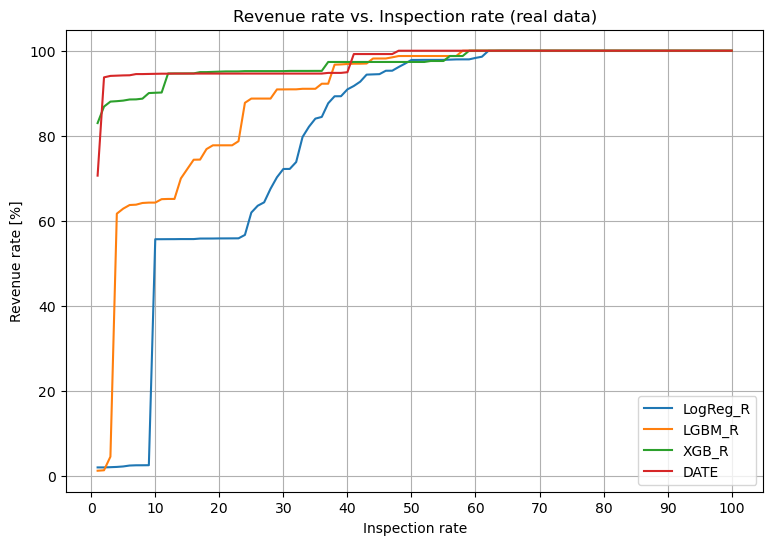

In [72]:
df_revenue_rate = df_insp_rate_summary[df_insp_rate_summary.index.str.startswith('revenue_rate')]

print(df_revenue_rate.to_markdown())

# Plotting
plt.figure(figsize=(9, 6))

plt.plot(df_insp_rate['inspection_rate'], 100*df_insp_rate['revenue_rate_LogReg_R'], label='LogReg_R')
plt.plot(df_insp_rate['inspection_rate'], 100*df_insp_rate['revenue_rate_LGBM_R'], label='LGBM_R')
plt.plot(df_insp_rate['inspection_rate'], 100*df_insp_rate['revenue_rate_XGB_R'], label='XGB_R')
plt.plot(df_insp_rate['inspection_rate'], 100*df_insp_rate['revenue_rate_DATE'], label='DATE')

# Adding labels and title
plt.xlabel('Inspection rate')
plt.ylabel('Revenue rate [%]')
plt.title('Revenue rate vs. Inspection rate (real data)')
plt.legend()
plt.xticks(range(0, 101, 10))

plt.grid(True)
# Show the plot
plt.show()

____________________________